# Imports and Config

## Imports

In [ ]:
!pip install datasets[vision]

In [ ]:
import numpy as np
import pandas as pd
import os
import tqdm
import random
import re
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import textwrap

from datasets import load_dataset

import torch
from torchvision import transforms
import torch
import torchtext

## Data Loading

### WikiArt Artist Data


In [ ]:
# load in wikiart artist information
artists_info = pd.read_csv('artists.csv')

In [ ]:
artist_names = set(list(artists_info['Name'].str.strip().str.lower()))

In [ ]:
movements = set(artists_info['ArtMovements'].str.split(',').explode().str.strip().str.lower().value_counts()[:15].index.tolist())

In [ ]:
movements

{'abstract art',
 'abstract expressionism',
 'academic art',
 'art nouveau',
 'baroque',
 'conceptual art',
 'contemporary',
 'expressionism',
 'impressionism',
 'minimalism',
 'pop art',
 'post-impressionism',
 'realism',
 'romanticism',
 'surrealism'}

In [ ]:
genres = set(artists_info['Genres'].str.split(',').explode().str.strip().str.lower().value_counts()[:15].index.tolist())

In [ ]:
genres

{'abstract',
 'animal painting',
 'cityscape',
 'figurative',
 'genre painting',
 'history painting',
 'illustration',
 'installation',
 'landscape',
 'marina',
 'photo',
 'portrait',
 'religious painting',
 'sculpture',
 'still life'}

### DiffusionDB Data

In [ ]:
# Load diffusionDB - random 10,000 images
gen_imgs = load_dataset('poloclub/diffusiondb', '2m_first_1k')
# load only img and prompt
gen_imgs = gen_imgs['train'].select_columns(['prompt', 'image'])

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
# get average image resolution
avg_res_y = gen_imgs['image']
avg_res_x = gen_imgs['image'].size().mean()
print(f'Average image resolution: {avg_res_x}x{avg_res_y}')

AttributeError: ignored

In [ ]:
np.array([i.size for i in gen_imgs['image']]).mean(axis=0)

array([583.808, 603.264])

## Data Sampling
Defines a helper function to take a random slice of data and plot it

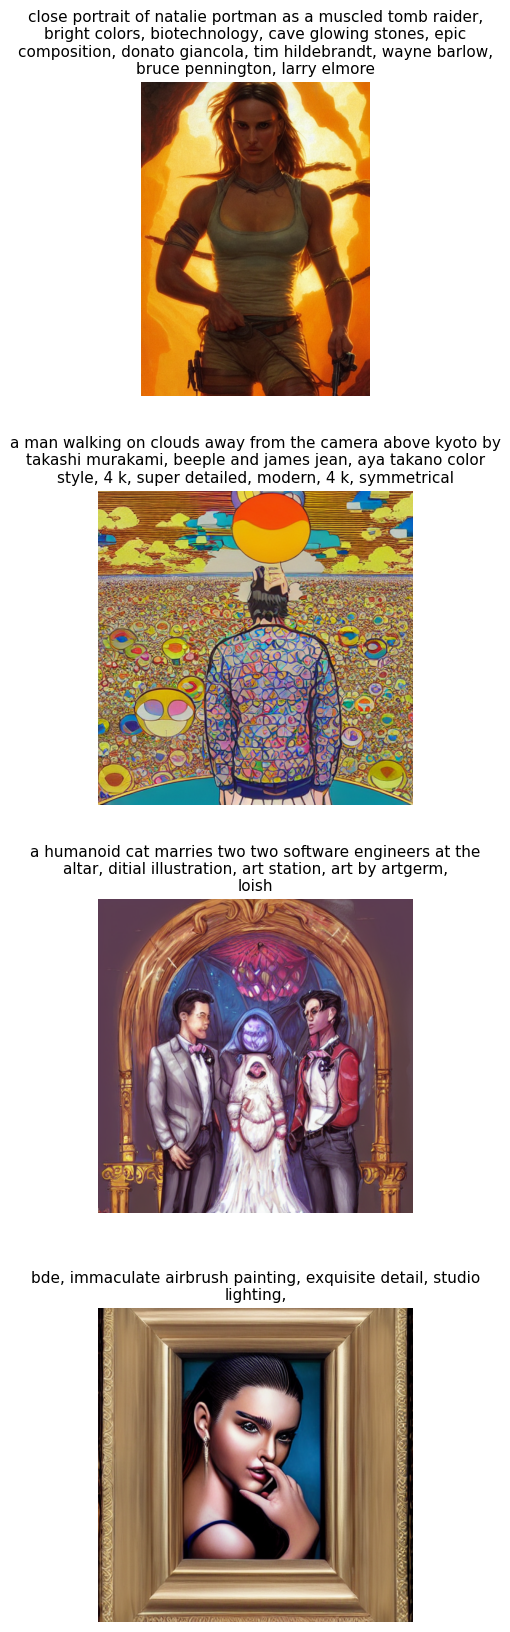

In [ ]:
def sample_data(indices, data):
  # helper function to show prompt and image
    num_rows = len(indices)

    # Create a new figure with subplots
    fig, axes = plt.subplots(num_rows, 1, figsize=(5, 5 * num_rows))

    # Iterate over the indices and plot images with wrapped titles
    for i, index in enumerate(indices):
        prompt = data[int(index)]['prompt']
        img = data[int(index)]['image']

        # Plot the image
        axes[i].imshow(img)
        axes[i].axis('off')

        # Wrap the prompt text to fit the width of the plot
        wrapped_text = textwrap.fill(prompt, width=60)  # Adjust the width as needed

        # Set the wrapped title of the subplot
        axes[i].set_title(wrapped_text, fontsize=11, ha='center')
    # add space to accomodate titles
    plt.subplots_adjust(hspace=0.3)

    # Show the plot
    plt.show()

def get_random_samples(sample_size, data):
  # function to get random promts and images
  random_indices = np.random.randint(0, len(data), sample_size)
  sample_data(random_indices, data)

  return data.select([int(i) for i in random_indices])

random_samples = get_random_samples(4, gen_imgs)

## Data Filtering

In [ ]:
# filter the data based on prompts with positive search terms and negative negation terms
filtered_rowsets = []
negation_terms = ['3d', 'sci-fi', 'digital', 'photo', 'photograph', 'photography', 'render', '4k', 'deviantart', 'cinematic', '4 k', 'cyberpunk']
art_terms = ['on canvas', 'oil painting', 'watercolours', 'watercolors', 'watercolor','acrylic', 'brush strokes', 'painting']
for filter_terms in [artist_names, genres, art_terms]:
  # filter positively on filter terms
  filtered = gen_imgs.filter(lambda x: any(s in x['prompt'].lower() for s in filter_terms))
  # filter negatively on negation terms
  filtered = filtered.filter(lambda x: not any(s in x['prompt'].lower() for s in negation_terms))
  filtered_rowsets.append(filtered)
  print(len(filtered))

12644
12522
10599


### Filtered data based on artist names
Here data is filtered based on it containing references to any artists contained in the wikiArt dataset

In [ ]:
random_artists = get_random_samples(10, filtered_rowsets[0])

Output hidden; open in https://colab.research.google.com to view.

### Filtered data based on art genres
Data here is filtered based on the prompt containing keywords consisting of the top 10 most frequently used genre of art an artist belongs to according to WikiArt

In [ ]:
random_genres = get_random_samples(10, filtered_rowsets[1])

Output hidden; open in https://colab.research.google.com to view.

### Filtered data based on art-words
Here data is filtered based on art keywords like oil painting, canvas, etc

In [ ]:
random_art_terms = get_random_samples(10, filtered_rowsets[2])

NameError: ignored